In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/modrec

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/modrec


In [ ]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses

import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(0)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
#from matplotlib import pyplot as plt
import pickle, random, sys
import keras
import keras.backend as K
from keras.callbacks import LearningRateScheduler,TensorBoard
from tensorflow.keras.optimizers import Adam
import csv
import mltools,rmldataset2016
#import rmlmodels.CNN2Model as cnn2

In [ ]:
import os
import numpy as np
import keras.models as models
from keras.layers import Reshape,Dense,Dropout,Activation,Flatten, Input
from keras.layers import Convolution2D,Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation
from keras.models import Model

def CNN2Model(weights=None,
             input_shape=[2,128],
             classes=11,
             **kwargs):
    if weights is not None and not (os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), '
                         'or the path to the weights file to be loaded.')

    dr = 0.6 # dropout rate (%)

    input = Input(shape=input_shape + [1], name='input')


    x = Reshape(target_shape=input_shape + [1])(input)


    x = Conv2D(50, (1, 8), padding='same', activation="leaky_relu", name="conv1", kernel_initializer='glorot_uniform')(x)
    x = Dropout(dr)(x)

    x = Conv2D(50, (2, 8), padding="valid", activation="leaky_relu", name="conv2", kernel_initializer='glorot_uniform')(x)
    x = Dropout(dr)(x)

    x = Flatten()(x)

    x = Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1")(x)
    x = Dropout(dr)(x)

    x = Dense(classes, kernel_initializer='he_normal', name="dense2")(x)
    output = Activation('softmax')(x)

    model = Model(inputs=input, outputs=output)

    # Load weights.
    if weights is not None:
        model.load_weights(weights)

    return model

if __name__ == '__main__':
    print(CNN2Model().summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2, 128, 1)]       0         
                                                                 
 reshape_5 (Reshape)         (None, 2, 128, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 2, 128, 50)        450       
                                                                 
 dropout_15 (Dropout)        (None, 2, 128, 50)        0         
                                                                 
 conv2 (Conv2D)              (None, 1, 121, 50)        40050     
                                                                 
 dropout_16 (Dropout)        (None, 1, 121, 50)        0         
                                                                 
 flatten_5 (Flatten)         (None, 6050)              0   

channels_last
220000
132000
44000
44000
(132000, 2, 128)
(44000, 2, 128)
(44000, 2, 128)
(132000, 11)
(44000, 11)
(44000, 11)
(132000, 2, 128) [2, 128]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2, 128, 1)]       0         
                                                                 
 reshape_7 (Reshape)         (None, 2, 128, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 2, 128, 50)        450       
                                                                 
 dropout_21 (Dropout)        (None, 2, 128, 50)        0         
                                                                 
 conv2 (Conv2D)              (None, 1, 121, 50)        40050     
         

FileNotFoundError: [Errno 2] No such file or directory: 'figure/total_loss.png'

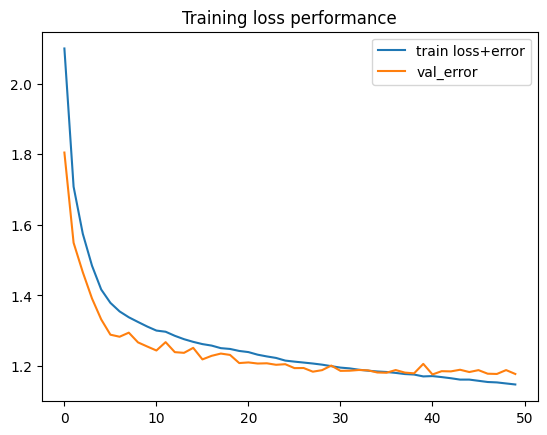

In [ ]:

#set Keras data format as channels_first
K.set_image_data_format('channels_last')
print(K.image_data_format())

(mods,snrs,lbl),(X_train,Y_train),(X_val,Y_val),(X_test,Y_test),(train_idx,val_idx,test_idx) = \
    rmldataset2016.load_data()

in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods
print(classes)


# Set up some params
nb_epoch = 50    # number of epochs to train on
batch_size = 500  # training batch size

model = cnn2.CNN2Model(None, input_shape=in_shp,classes=len(classes))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.summary()

filepath = 'weights/weights.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=[X_val,Y_val],
    callbacks = [
                keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
                keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,verbose=1,patince=5,min_lr=0.000001),
                keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto')
                #keras.callbacks.TensorBoard(log_dir='./logs/',histogram_freq=1,write_graph=False,write_grads=1,write_images=False,update_freq='epoch')
                ]
                    )

mltools.show_history(history)

#Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=1, batch_size=batch_size)
print(score)

def predict(model):
    # Plot confusion matrix
    model.load_weights(filepath)
    test_Y_hat = model.predict(X_test, batch_size=batch_size)
    confnorm,_,_ = mltools.calculate_confusion_matrix(Y_test,test_Y_hat,classes)
    mltools.plot_confusion_matrix(confnorm, labels=['8PSK','AM-DSB','AM-SSB','BPSK','CPFSK','GFSK','4-PAM','16-QAM','64-QAM','QPSK','WBFM'],save_filename='figure/cnn2_total_confusion')

    # Plot confusion matrix
    acc = {}
    acc_mod_snr = np.zeros( (len(classes),len(snrs)) )
    i = 0
    for snr in snrs:

        # extract classes @ SNR
        # test_SNRs = map(lambda x: lbl[x][1], test_idx)
        test_SNRs = [lbl[x][1] for x in test_idx]

        test_X_i = X_test[np.where(np.array(test_SNRs) == snr)]
        test_Y_i = Y_test[np.where(np.array(test_SNRs) == snr)]

        # estimate classes
        test_Y_i_hat = model.predict(test_X_i)
        confnorm_i,cor,ncor = mltools.calculate_confusion_matrix(test_Y_i,test_Y_i_hat,classes)
        acc[snr] = 1.0 * cor / (cor + ncor)
        result = cor / (cor + ncor)
        with open('acc111.csv', 'a', newline='') as f0:
            write0 = csv.writer(f0)
            write0.writerow([result])
        mltools.plot_confusion_matrix(confnorm_i, labels=['8PSK','AM-DSB','AM-SSB','BPSK','CPFSK','GFSK','4-PAM','16-QAM','64-QAM','QPSK','WBFM'], title="Confusion Matrix",save_filename="figure/Confusion(SNR=%d)(ACC=%2f).png" % (snr,100.0*acc[snr]))

        acc_mod_snr[:,i] = np.round(np.diag(confnorm_i)/np.sum(confnorm_i,axis=1),3)
        i = i +1

    #plot acc of each mod in one picture
    dis_num=11
    for g in range(int(np.ceil(acc_mod_snr.shape[0]/dis_num))):
        assert (0 <= dis_num <= acc_mod_snr.shape[0])
        beg_index = g*dis_num
        end_index = np.min([(g+1)*dis_num,acc_mod_snr.shape[0]])

        plt.figure(figsize=(12, 10))
        plt.xlabel("Signal to Noise Ratio")
        plt.ylabel("Classification Accuracy")
        plt.title("Classification Accuracy for Each Mod")

        for i in range(beg_index,end_index):
            plt.plot(snrs, acc_mod_snr[i], label=classes[i])
            # 设置数字标签
            for x, y in zip(snrs, acc_mod_snr[i]):
                plt.text(x, y, y, ha='center', va='bottom', fontsize=8)

        plt.legend()
        plt.grid()
        plt.savefig('figure/acc_with_mod_{}.png'.format(g+1))
        plt.close()
    #save acc for mod per SNR
    fd = open('predictresult/acc_for_mod_on_cnn2.dat', 'wb')
    pickle.dump(('128','cnn2', acc_mod_snr), fd)
    fd.close()

    # Save results to a pickle file for plotting later
    print(acc)
    fd = open('predictresult/cnn2_d0.5.dat','wb')
    pickle.dump( ("CNN2", 0.5, acc) , fd )

    # Plot accuracy curve
    plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
    plt.xlabel("Signal to Noise Ratio")
    plt.ylabel("Classification Accuracy")
    plt.title("Classification Accuracy on RadioML 2016.10 Alpha")
    plt.tight_layout()
    plt.savefig('figure/each_acc.png')
    plt.close()
predict(model)